<a href="https://colab.research.google.com/github/marama09/Eyes_Disease/blob/main/Cataract_Eyes_Disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project, I performed a superficial exploratory data analysis, investigated the relationship between diagnostic keyphrases and diagnosed conditions and, based on the latter, implemented some code to sort images of retinal fundi, according to conditions whose symptoms they display.



In [ ]:
# Import everything we need 
import os
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt, image as mpimg
from tqdm import tqdm
from time import time
from collections import Counter
import random
import glob
import seaborn as sns
%matplotlib inline 
from sklearn.metrics import classification_report
from wordcloud import WordCloud, STOPWORDS
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, utils, callbacks
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from keras.utils import np_utils
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Reshape, Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import re
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set up all the paths
train_dir = '/content/drive/MyDrive/Ocular Disease/ODIR-5K/Training Images/'
img_dir = "/content/drive/MyDrive/Ocular Disease/preprocessed_images"
IMG_DIR = '/content/drive/MyDrive/Ocular Disease/ODIR-5K/Training Images/'
file_names = sorted(os.listdir(IMG_DIR))
DATA_FOLDER='/content/drive/MyDrive/Ocular Disease/ODIR-5K/Training Images'

First, let's load our data to a DataFrame and take a look at it



In [ ]:
df= pd.read_csv("/content/drive/MyDrive/Ocular Disease/full_df.csv")
df.head()

ID  Patient Age Patient Sex  ... labels                    target     filename
0   0           69      Female  ...  ['N']  [1, 0, 0, 0, 0, 0, 0, 0]  0_right.jpg
1   1           57        Male  ...  ['N']  [1, 0, 0, 0, 0, 0, 0, 0]  1_right.jpg
2   2           42        Male  ...  ['D']  [0, 1, 0, 0, 0, 0, 0, 0]  2_right.jpg
3   4           53        Male  ...  ['D']  [0, 1, 0, 0, 0, 0, 0, 0]  4_right.jpg
4   5           50      Female  ...  ['D']  [0, 1, 0, 0, 0, 0, 0, 0]  5_right.jpg

[5 rows x 19 columns]

In [ ]:
#Rename columns
df.columns = ["ID", 'Age', "Patient Sex", "Left_Fundus", "Right_Fundus", "Left_Diagnostic", "Right_Diagnostic","Normal","Diabetes", "Glaucoma", "Cataract", "Amd", "Hypertension", "Myopia", "Other","filepath","labels", "target", "filename"]

In [ ]:
df.head()

ID  Age Patient Sex  ... labels                    target     filename
0   0   69      Female  ...  ['N']  [1, 0, 0, 0, 0, 0, 0, 0]  0_right.jpg
1   1   57        Male  ...  ['N']  [1, 0, 0, 0, 0, 0, 0, 0]  1_right.jpg
2   2   42        Male  ...  ['D']  [0, 1, 0, 0, 0, 0, 0, 0]  2_right.jpg
3   4   53        Male  ...  ['D']  [0, 1, 0, 0, 0, 0, 0, 0]  4_right.jpg
4   5   50      Female  ...  ['D']  [0, 1, 0, 0, 0, 0, 0, 0]  5_right.jpg

[5 rows x 19 columns]

In [ ]:
print(f"data shape: {df.shape}")
print(f"Left-Fundus: {df.Left_Fundus.nunique()}")
print(f"right fundus: {df.Right_Fundus.nunique()}")

data shape: (6392, 19)
Left-Fundus: 3358
right fundus: 3358


**We have 6392 records, and unique images associated with each record for left and respectively right eye.**

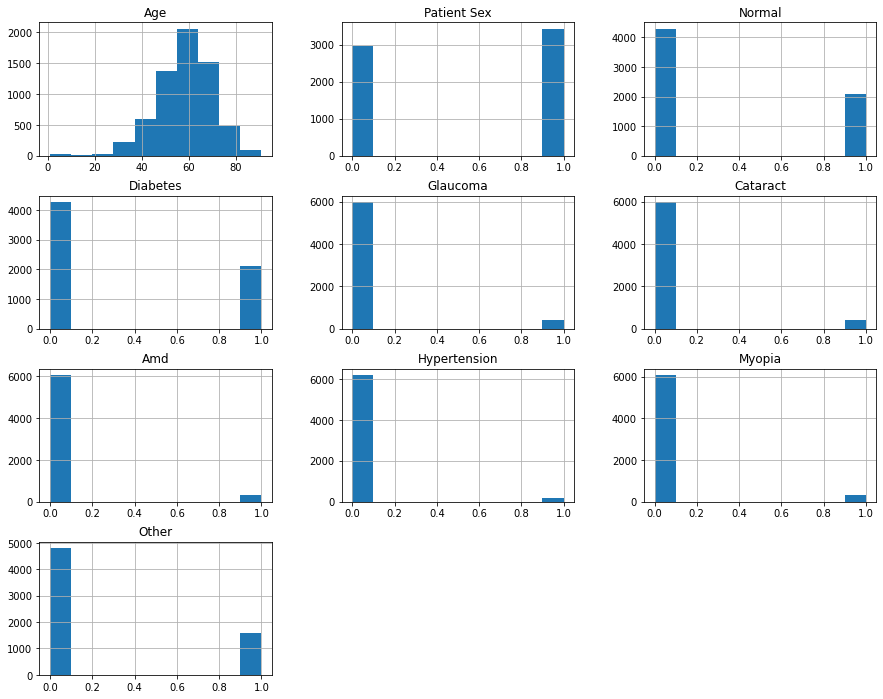

In [ ]:
data_num = df.copy()[['Age', 'Patient Sex', "Normal","Diabetes", "Glaucoma", "Cataract", "Amd", "Hypertension", "Myopia", "Other"]]
data_num['Patient Sex'] = data_num['Patient Sex'].apply(lambda x:0  if x=='Female' else 1) # we encode sex: Female => 0; Male => 1

data_num.hist(figsize=(15,12))

plt.show()

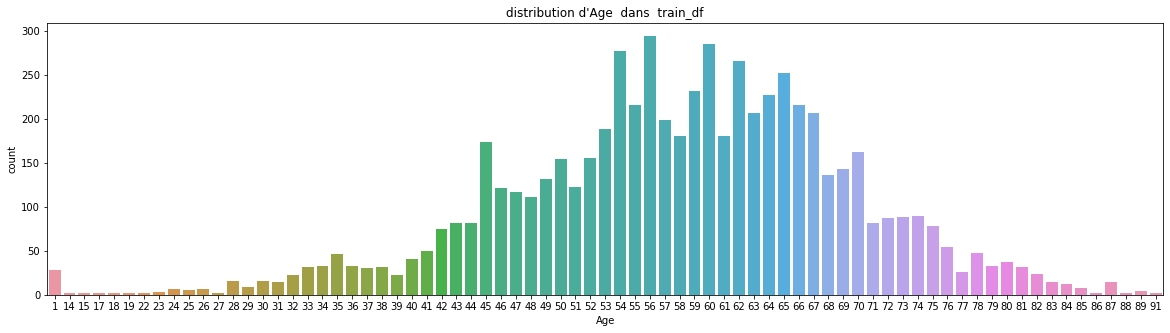

In [ ]:
fig, (ax1) = plt.subplots(1, 1, figsize=(20,5))
sns.countplot(ax=ax1, x="Age", data=df)
ax1.set_title("distribution d'Age  dans  train_df")
plt.show()

We can see a few interesting things here:

1) The most prominent age group are people in about their 60s.

2) There is slightly more males than females.

3) Most patients are not healthy, but healthy patients are the most prevalent of all groups.

4) The most prevalent non-healthy group are patients with diabetes, with "other" coming right after them.

Since this "other" category likely lumps many non-related and quite heterogenous conditions, it's going to be more efficient to focus on diabetic patients.

For now, we will build a model which will discriminate healthy retinas from those displaying signs of diabetes. Later we will test its performance how it performs on the images of retinas with signs of other diseases and see whether we can gain some insight from it.

One more thing: let's take a peek at correlations

**Check image data**
We check now the image data for completeness.

In [ ]:
print(f"train images: {len(os.listdir('/content/drive/MyDrive/Ocular Disease/ODIR-5K/Training Images'))}")

train images: 7122


In [ ]:
%matplotlib inline
def plot_count(feature, title, df, size=1, show_all=False):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    if show_all:
        g = sns.countplot(df[feature], palette='Set3')
        g.set_title("{} distribution".format(title))
    else:
        g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette='Set3')
        if(size > 2):
            plt.xticks(rotation=90, size=8)
            for p in ax.patches:
                height = p.get_height()
                ax.text(p.get_x()+p.get_width()/2.,
                        height + 0.2,
                        '{:1.2f}%'.format(100*height/total),
                        ha="center") 
        g.set_title("Number{}".format(title))
        plt.show()    

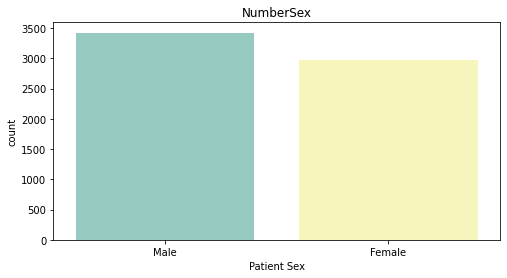

In [ ]:
plot_count("Patient Sex", "Sex", df, size=2);

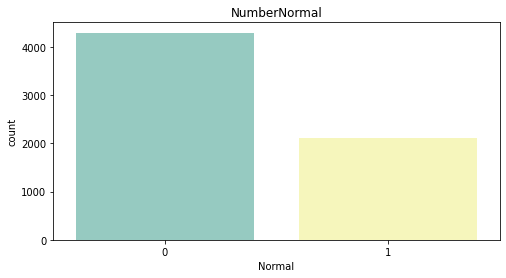

In [ ]:
plot_count("Normal", "Normal", df, size=2);

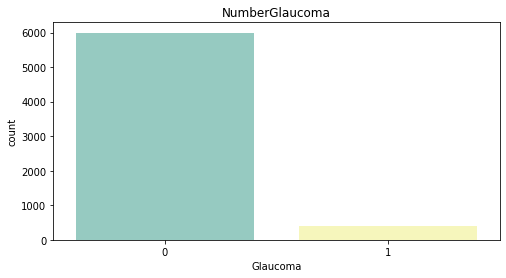

In [ ]:
plot_count("Glaucoma", "Glaucoma", df, size=2);

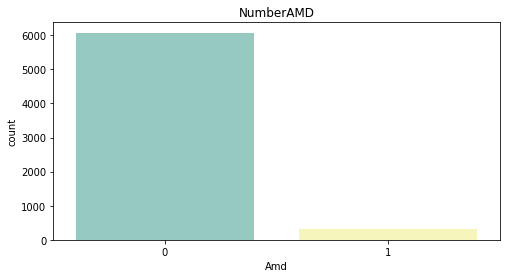

In [ ]:
plot_count("Amd", "AMD", df, size=2);

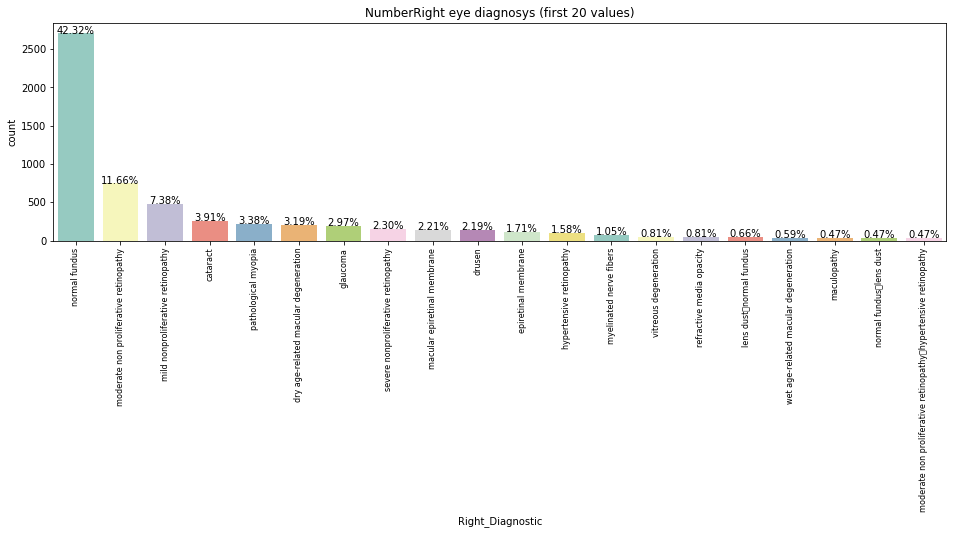

In [ ]:
plot_count("Right_Diagnostic", "Right eye diagnosys (first 20 values)", df, size=4)

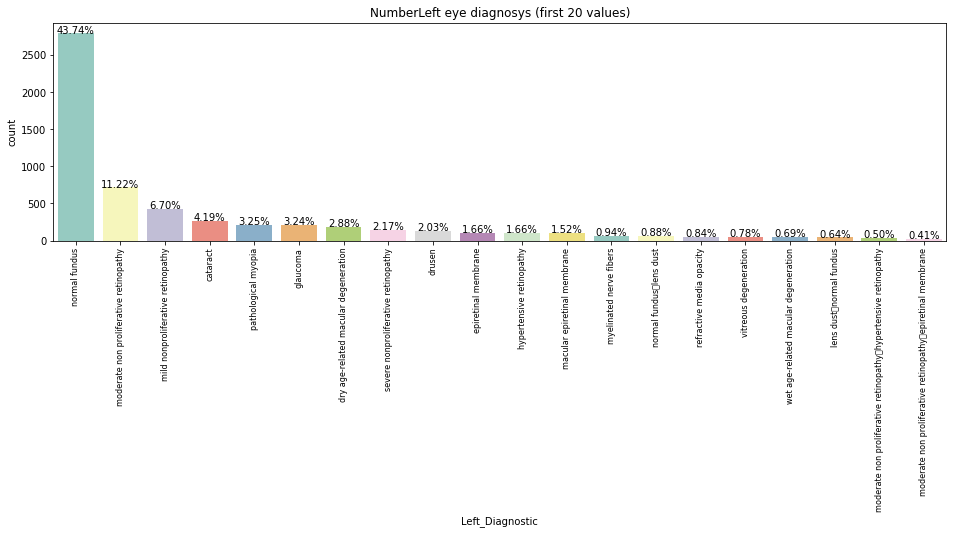

In [ ]:
plot_count("Left_Diagnostic", "Left eye diagnosys (first 20 values)", df, size=4)

Let's check now frequence of words used in diagnosys for left and right eye, as a wordcloud, to see what are the most frequent words used in such diagnosys.


In [ ]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=40,
        max_font_size=40, 
        scale=3,
        random_state=1,
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [ ]:
df.loc[(df.Cataract==1)]['Left_Diagnostic'].value_counts()

cataract                                                                   268
normal fundus                                                               48
moderate non proliferative retinopathy                                      12
cataract，lens dust                                                          12
mild nonproliferative retinopathy                                           10
refractive media opacity                                                     6
cataract，moderate non proliferative retinopathy                              6
normal fundus，lens dust                                                      6
severe proliferative diabetic retinopathy                                    4
cataract，mild nonproliferative retinopathy                                   4
lens dust，cataract                                                           3
lens dust，normal fundus                                                      3
hypertensive retinopathy                            

In [ ]:
df.loc[(df.Cataract==1)]['Right_Diagnostic'].value_counts()

cataract                                                      250
normal fundus                                                  48
moderate non proliferative retinopathy                         18
drusen                                                         10
cataract，lens dust                                              9
refractive media opacity                                        8
mild nonproliferative retinopathy                               8
cataract，moderate non proliferative retinopathy                 6
moderate non proliferative retinopathy，cataract                 6
macular epiretinal membrane                                     6
epiretinal membrane                                             6
hypertensive retinopathy，cataract                               4
cataract，laser spot，moderate non proliferative retinopathy      2
moderate non proliferative retinopathy，laser spot               2
cataract，suspected cataract                                     2
cataract，b

In [ ]:
df2= df.iloc[:, 1:7]
#df_data2['filepath'] = pd.Series(df_data['filepath'])
df2.head()

Age  ...                        Right_Diagnostic
0   69  ...                           normal fundus
1   57  ...                           normal fundus
2   42  ...  moderate non proliferative retinopathy
3   53  ...       mild nonproliferative retinopathy
4   50  ...  moderate non proliferative retinopathy

[5 rows x 6 columns]

In [ ]:
df_left_cat = df2[df2['Left_Diagnostic'].str.match('cataract')]
print(len(df_left_cat))

294


In [ ]:
# Left diagnosis with 'cataract' keyword
df2[df2['Left_Diagnostic'].str.match('cataract')].head()

Age Patient Sex  ... Left_Diagnostic             Right_Diagnostic
0     69      Female  ...        cataract                normal fundus
86    55      Female  ...        cataract                normal fundus
100   59        Male  ...        cataract                       drusen
218   60      Female  ...        cataract  macular epiretinal membrane
256   69      Female  ...        cataract                normal fundus

[5 rows x 6 columns]

In [ ]:
df_left_cat = df2[df2['Left_Diagnostic'].str.match('cataract')]
print(len(df_left_cat))

294


In [ ]:
df_rt_cat = df[df['Right_Diagnostic'].str.match('cataract')]
print(len(df_rt_cat))

278


In [ ]:
# Right diagnosis with 'cataract' keyword
df2[df2['Right_Diagnostic'].str.match('cataract')].head()

Age  ... Right_Diagnostic
20    75  ...         cataract
93    57  ...         cataract
160   55  ...         cataract
186   36  ...         cataract
309   65  ...         cataract

[5 rows x 6 columns]

In [ ]:
df_cat_filenames = df_left_cat['Left_Fundus'].append(df_rt_cat['Right_Fundus'], ignore_index=True)
df_cat_filenames.head()

0      0_left.jpg
1    103_left.jpg
2    119_left.jpg
3    254_left.jpg
4    294_left.jpg
dtype: object

In [ ]:
## let's place the Normal data into its own dataframe and print the number of rows
df_rt_norm = df[df['Right_Diagnostic'].str.match('normal')]
print(len(df_rt_norm))

2735


In [ ]:
## let's place the Normal data into its own dataframe and print the number of rows

df_left_norm = df[df['Left_Diagnostic'].str.match('normal')]
print(len(df_left_norm))

2855


In [ ]:
#Combine normal filename data
df_norm_filenames = df_left_norm['Left_Fundus'].append(df_rt_norm['Right_Fundus'], ignore_index=True)
df_norm_filenames

0           1_left.jpg
1           8_left.jpg
2           9_left.jpg
3          14_left.jpg
4          15_left.jpg
             ...      
5585    4642_right.jpg
5586    4644_right.jpg
5587    4660_right.jpg
5588    4671_right.jpg
5589    4689_right.jpg
Length: 5590, dtype: object

In [ ]:
df_norm_filenames_random = df_norm_filenames.sample(n = 572)
df_norm_filenames_random.head()

156       885_left.jpg
460      2548_left.jpg
3539    2767_right.jpg
4009    3270_right.jpg
1244     3427_left.jpg
dtype: object

In [ ]:
#Add category label to list
df_cat_filenames = pd.DataFrame(df_cat_filenames, columns = ["filename"])

# add a new column of '1' to the dataframe
df_cat_filenames["label"] = "cataract"

df_cat_filenames.head()

filename     label
0    0_left.jpg  cataract
1  103_left.jpg  cataract
2  119_left.jpg  cataract
3  254_left.jpg  cataract
4  294_left.jpg  cataract

In [ ]:
df_norm_filenames_random = pd.DataFrame(df_norm_filenames_random, columns = ["filename"])
#df_cat_filenames.set_index("filename", inplace = True)

# add a new column of '1' to the dataframe
df_norm_filenames_random["label"] = "normal"

df_norm_filenames_random.head()

filename   label
156     885_left.jpg  normal
460    2548_left.jpg  normal
3539  2767_right.jpg  normal
4009  3270_right.jpg  normal
1244   3427_left.jpg  normal

In [ ]:
#Append dataframes into a single dataset
df_combined = df_cat_filenames.append(df_norm_filenames_random, ignore_index=True)
df_combined

filename     label
0         0_left.jpg  cataract
1       103_left.jpg  cataract
2       119_left.jpg  cataract
3       254_left.jpg  cataract
4       294_left.jpg  cataract
...              ...       ...
1139   3294_left.jpg    normal
1140  2993_right.jpg    normal
1141  1114_right.jpg    normal
1142   2809_left.jpg    normal
1143    633_left.jpg    normal

[1144 rows x 2 columns]

In [ ]:
df_combined_random = df_combined.sample(frac=1).reset_index(drop=True)
df_combined_random

filename     label
0      2240_left.jpg  cataract
1      2663_left.jpg    normal
2      2462_left.jpg    normal
3     2766_right.jpg    normal
4     2173_right.jpg  cataract
...              ...       ...
1139  2211_right.jpg  cataract
1140   1987_left.jpg  cataract
1141   1485_left.jpg    normal
1142   769_right.jpg  cataract
1143   2157_left.jpg  cataract

[1144 rows x 2 columns]

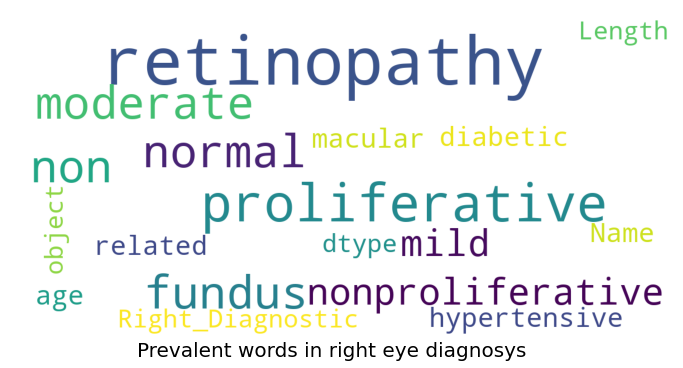

In [ ]:
show_wordcloud(df['Right_Diagnostic'], title = 'Prevalent words in right eye diagnosys')

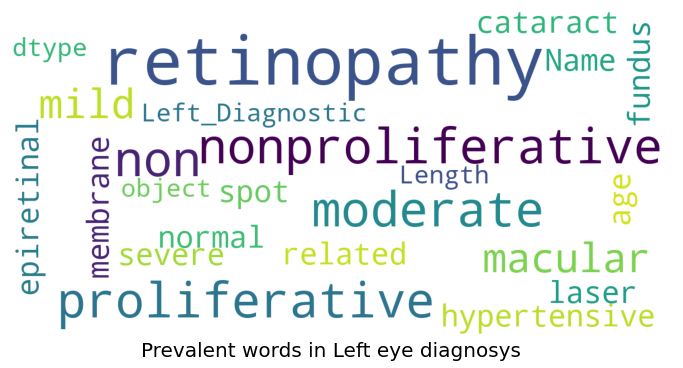

In [ ]:
show_wordcloud(df['Left_Diagnostic'], title = 'Prevalent words in Left eye diagnosys')

We can observe that the words used in diagnosys are quite balanced from the point of view of the two eyes.

Let's look now to people with cataract and check what are the associated texts for left and right diagnosys,

In [ ]:
# Crude estimation of findings ratio
findings = df.iloc[:, -12:-4]
totals = findings.sum()
totals

Normal          2101
Diabetes        2123
Glaucoma         397
Cataract         402
Amd              319
Hypertension     203
Myopia           306
Other           1588
dtype: int64

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

labels = ['Diabetes','Normal', 'Glaucoma', 'Cataract', 'Age related Macular Degeneration', 'Hypertension', 'Pathological Myopia', 'Other abnormalities']

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, values = [2101, 2123, 397, 402,319,203,306,1588]),
              1, 1)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    #title_text="Global",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Eyes diagnosis', x=0.15, y=0.5, font_size=16, showarrow=False)])
fig.show()

In [ ]:
# Helper functions
def filter_df(df, letter):
    filtered = df.loc[(df[letter] == 1)]
    return filtered


def display_grid(df, keyword):
    rows = 2
    cols = 4
    nr_images = rows*cols
    axes=[]
    fig=plt.figure(figsize=(16,8))
    filtered = df.loc[df['Left_Diagnostic'].str.contains(keyword)]
    
    if filtered.shape[0] < nr_images:
        nr_images = filtered.shape[0]

    for i in range(nr_images):
        file_name = filtered.iloc[i]['ID']
        file_name = str(file_name) + '_left.jpg'
        image = cv2.imread(os.path.join(IMG_DIR, file_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # crop horizontal image for esthetics
        if image.shape[1] > image.shape[0]:
            w = image.shape[0]
            x = (image.shape[1] - w)//2
            image = image[:, x:x+w]

        axes.append( fig.add_subplot(rows, cols, i+1) )
        subplot_title = filtered.iloc[i]['Left_Diagnostic']
        # replacing symbol that looks like comma but doesn't show correctly with a regular comma
        subplot_title = subplot_title.replace('，', ', ')  
        axes[-1].set_title('\n'.join(wrap(subplot_title,40)))  
        plt.axis('off')
        plt.imshow(image)
        
    fig.tight_layout()    
    plt.show()

In [ ]:
#Normal
df_N = filter_df(df, 'Normal')
normal = df_N.shape[0]/df.shape[0]*100
normal_f = "{:.2f}".format(normal)
print(f'fraction of healthy patients: {normal_f}%')

fraction of healthy patients: 32.87%


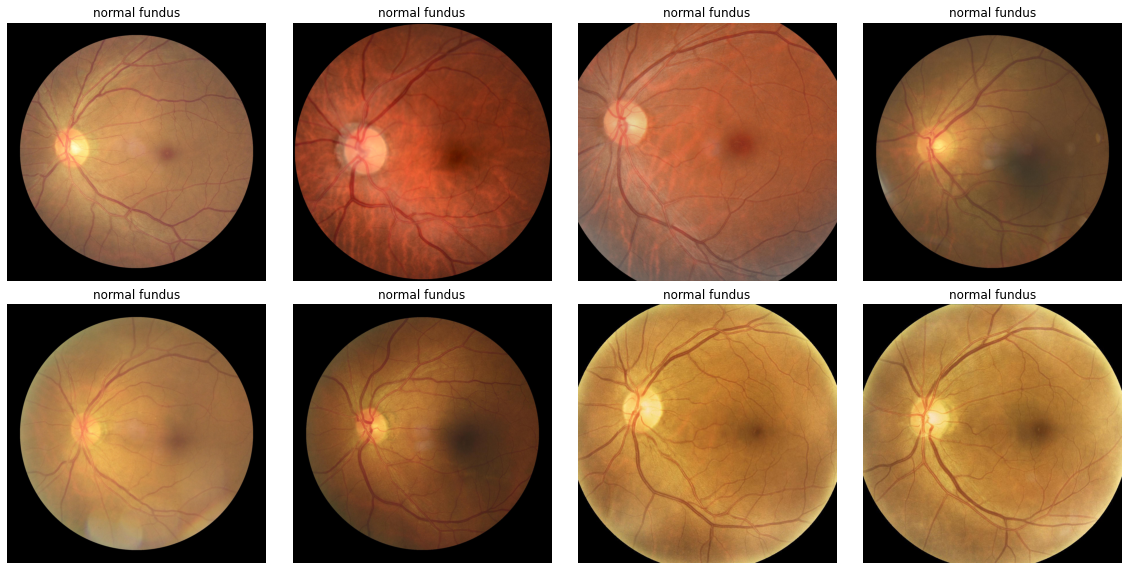

In [ ]:
import cv2
from textwrap import wrap
display_grid(df_N, 'normal fundus')

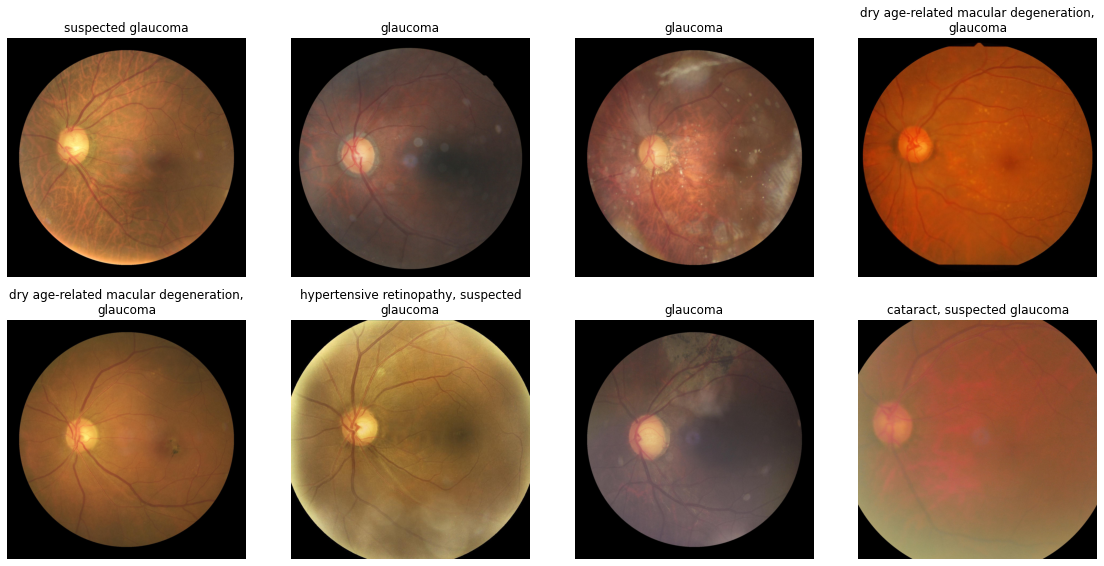

In [ ]:
#Glaucoma
df_G = filter_df(df, 'Glaucoma')
display_grid(df_G, 'glaucoma')

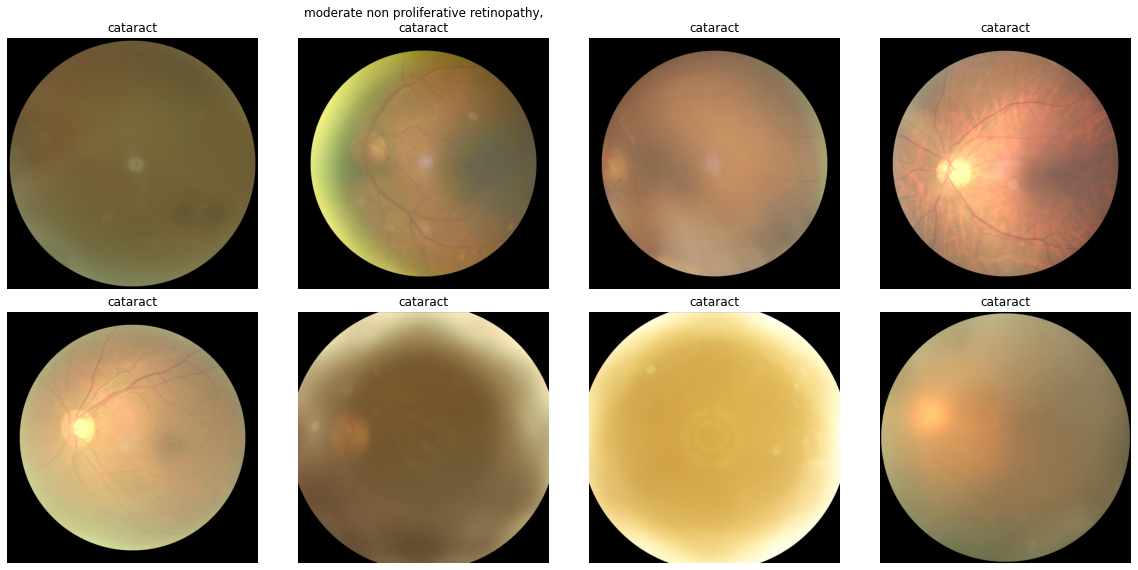

In [ ]:
#Cataract
df_C = filter_df(df, 'Cataract')
display_grid(df_C, 'cataract')

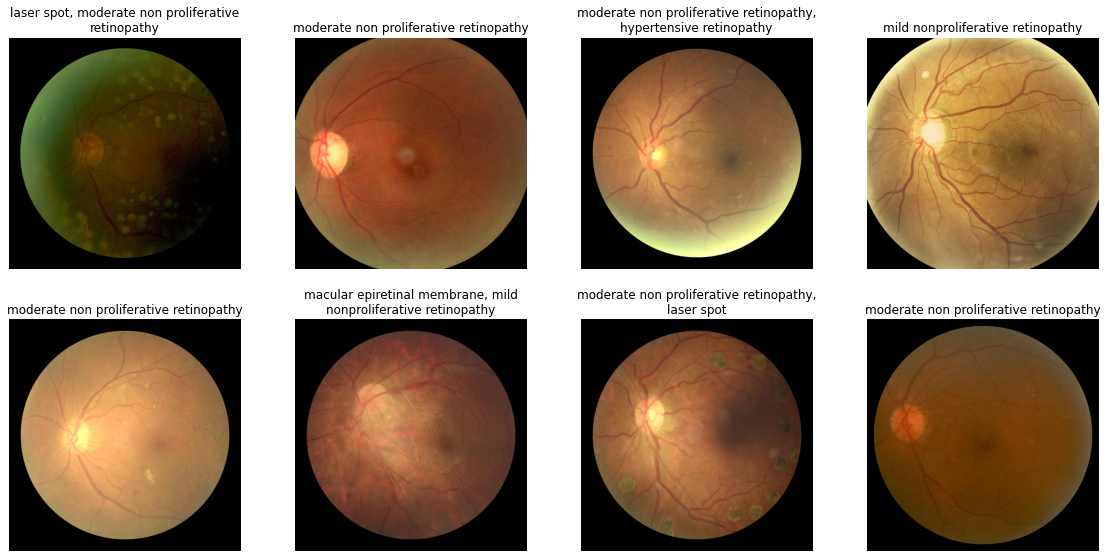

In [ ]:
#Diabetes
df_D = filter_df(df, 'Diabetes')
display_grid(df_D, 'proliferative retinopathy')

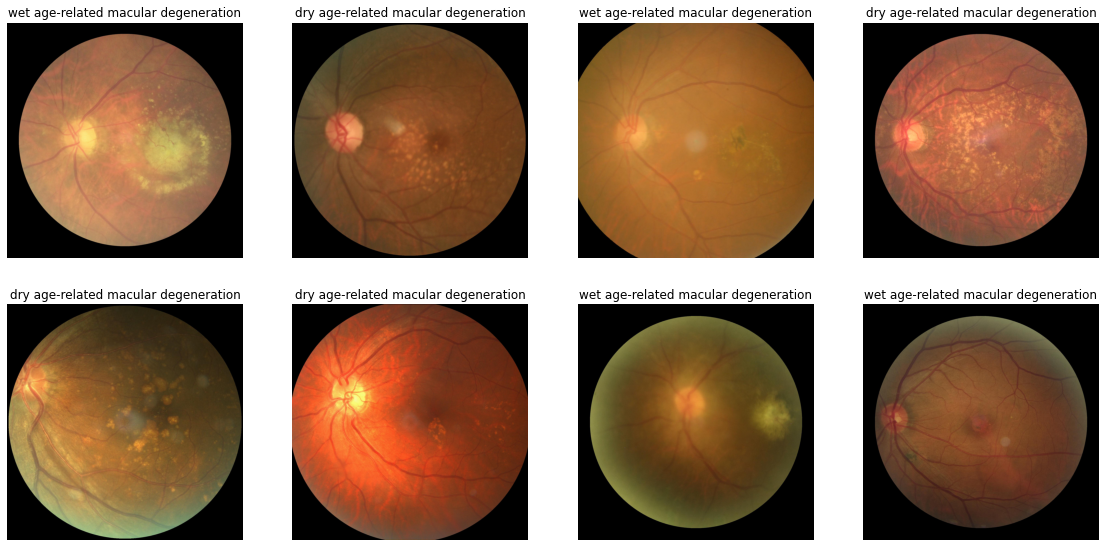

In [ ]:
#Age-related Macular Degeneration (AMD)
df_A = filter_df(df, 'Amd')
display_grid(df_A, 'age-related')

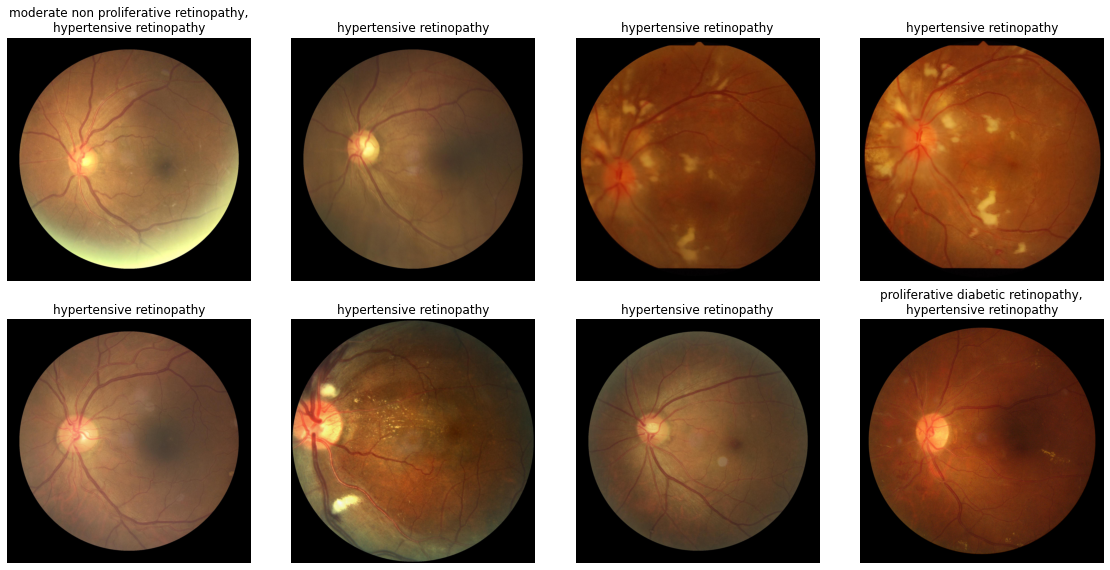

In [ ]:
#Hypertension
df_H = filter_df(df, 'Hypertension')
display_grid(df_H, 'hypertensive')

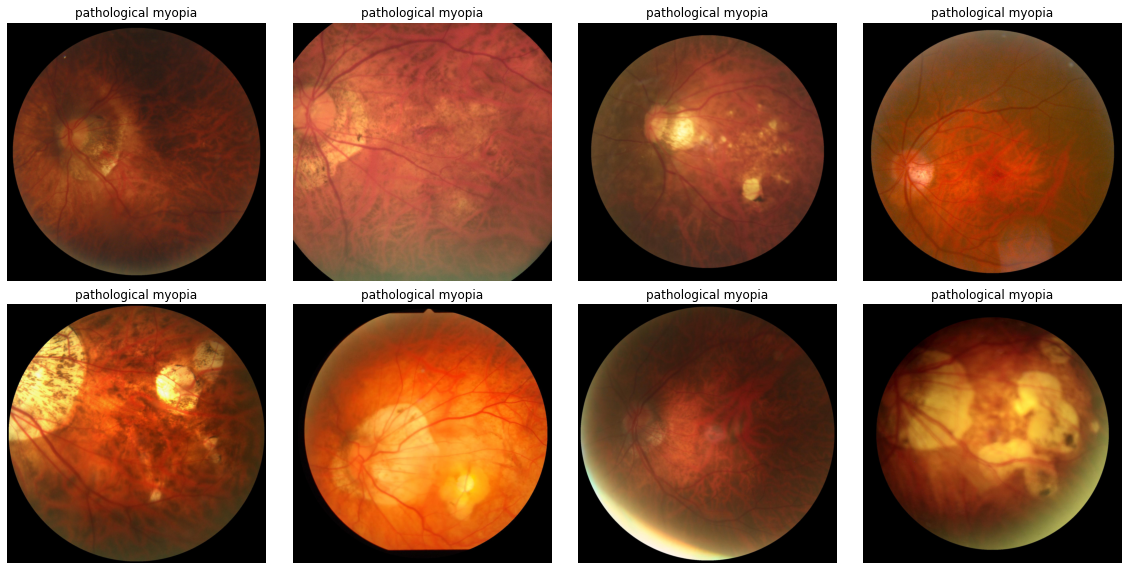

In [ ]:
#Pathological Myopia
df_M = filter_df(df, 'Myopia')
display_grid(df_M, 'myopia')

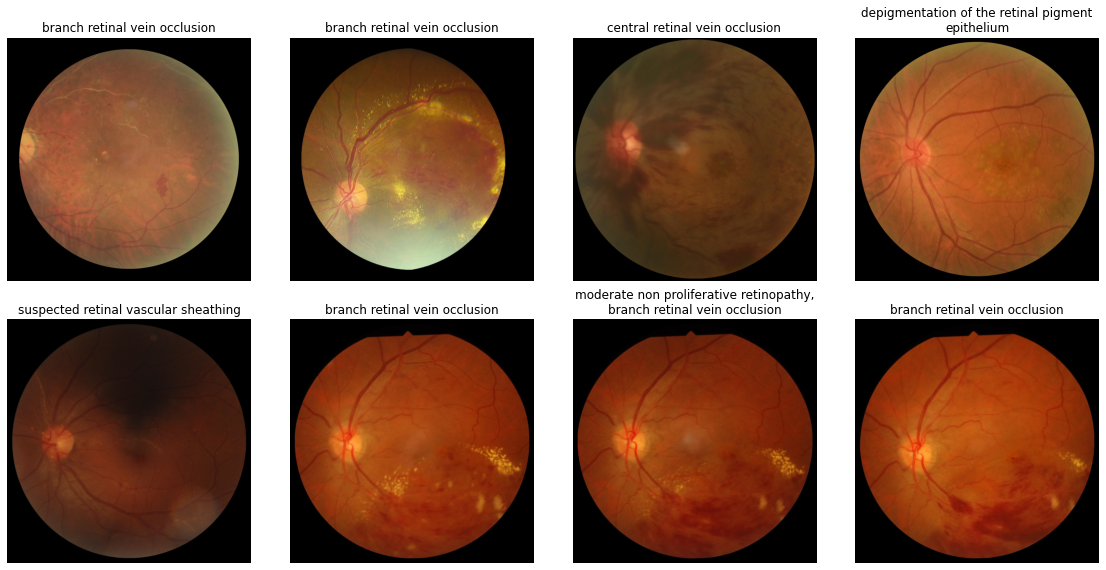

In [ ]:
#Other abnormalities
df_O = filter_df(df, 'Other')
display_grid(df_O, ' retinal')

**Randomize our final combined dataset**

In [ ]:
print(df.loc[(df.Cataract==1)].shape)
print(df.loc[df.Cataract==0].shape)

(402, 19)
(5990, 19)


In [ ]:
def has_cataract_mentioned(text):
    if 'cataract' in text:
        return 1
    else:
        return 0

In [ ]:
df['le_cataract'] = df['Left_Diagnostic'].apply(lambda x: has_cataract_mentioned(x))
df['re_cataract'] = df['Right_Diagnostic'].apply(lambda x: has_cataract_mentioned(x))

In [ ]:
cataract_le_list = df.loc[(df.Cataract==1) & (df.le_cataract==1)]['Left_Fundus'].values
cataract_re_list = df.loc[(df.Cataract==1) & (df.re_cataract==1)]['Right_Fundus'].values
print(len(cataract_le_list), len(cataract_re_list))
non_cataract_le_list = df.loc[(df.Cataract==0) & (df.Left_Diagnostic=="normal fundus")]['Left_Fundus'].sample(304, random_state=314).values
non_cataract_re_list = df.loc[(df.Cataract==0) & (df.Right_Diagnostic=="normal fundus")]['Right_Fundus'].sample(290, random_state=314).values
print(len(non_cataract_le_list), len(non_cataract_re_list))

304 290
304 290


In [ ]:
cataract_list = np.concatenate((cataract_le_list, cataract_re_list), axis = 0)
non_cataract_list = np.concatenate((non_cataract_le_list, non_cataract_re_list), axis = 0)
print(len(non_cataract_list), len(cataract_list))

594 594


In [ ]:
def label_image(label):
    if label == 1:
        return [1,0]
    elif label == 0: 
        return [0,1]

def process_data(data_image_list, DATA_FOLDER, is_cataract):
    data_df = []
    for img in tqdm(data_image_list):
        path = os.path.join(DATA_FOLDER,img)
        label = label_image(is_cataract)
        img = cv.imread(path,cv.IMREAD_COLOR)
        img = cv.resize(img, (IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA)
        data_df.append([np.array(img),np.array(label)])
    shuffle(data_df)
    return data_df

In [ ]:
from random import shuffle
import cv2  as cv
IMG_SIZE = 224
BATCH_SIZE = 32
NO_EPOCHS = 50
NUM_CLASSES = 2

In [ ]:
cat_df = process_data(cataract_list, DATA_FOLDER, 1)

100%|██████████| 594/594 [00:53<00:00, 11.00it/s]


In [ ]:
cat_no_df = process_data(non_cataract_list, DATA_FOLDER, 0)

100%|██████████| 594/594 [00:46<00:00, 12.88it/s]


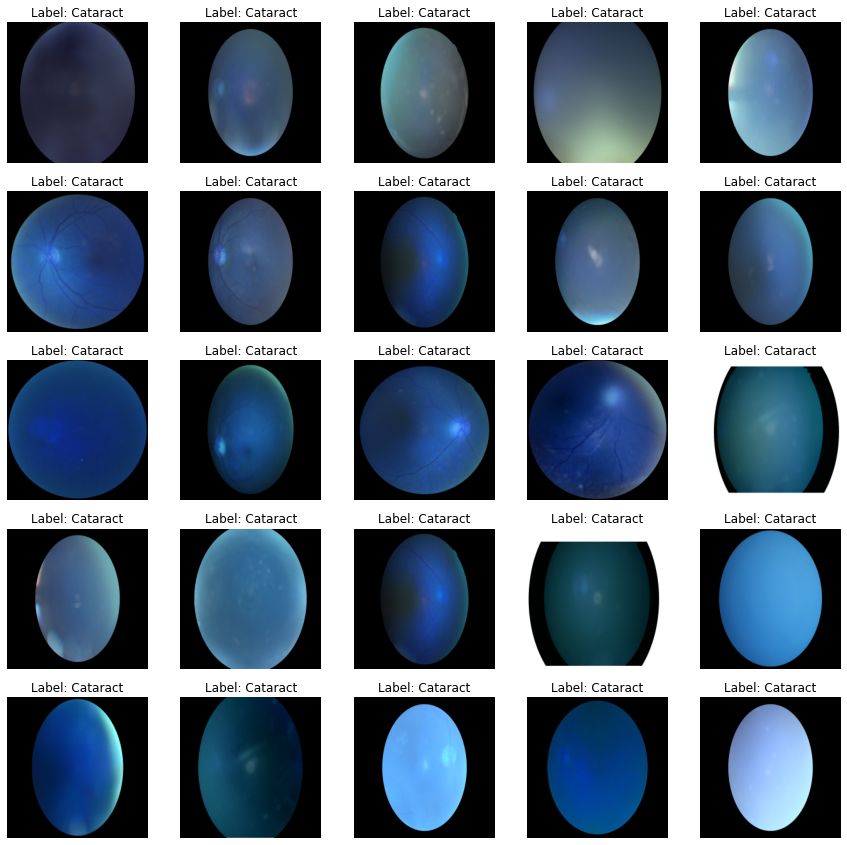

In [ ]:
def show_images(data, isTest=False):
    f, ax = plt.subplots(5,5, figsize=(15,15))
    for i,data in enumerate(data[:25]):
        img_num = data[1]
        img_data = data[0]
        label = np.argmax(img_num)
        if label  == 0: 
            str_label='Cataract'
        elif label == 1: 
            str_label='No Cataract'
        if(isTest):
            str_label="None"
        ax[i//5, i%5].imshow(img_data)
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title("Label: {}".format(str_label))
    plt.show()

show_images(cat_df)

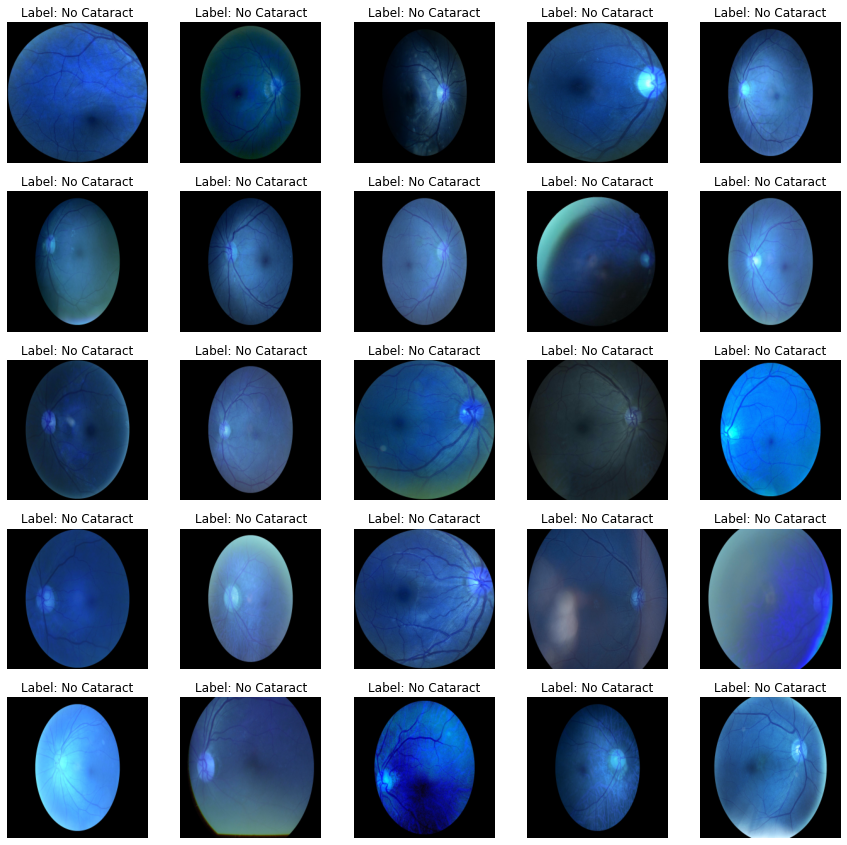

In [ ]:
show_images(cat_no_df)

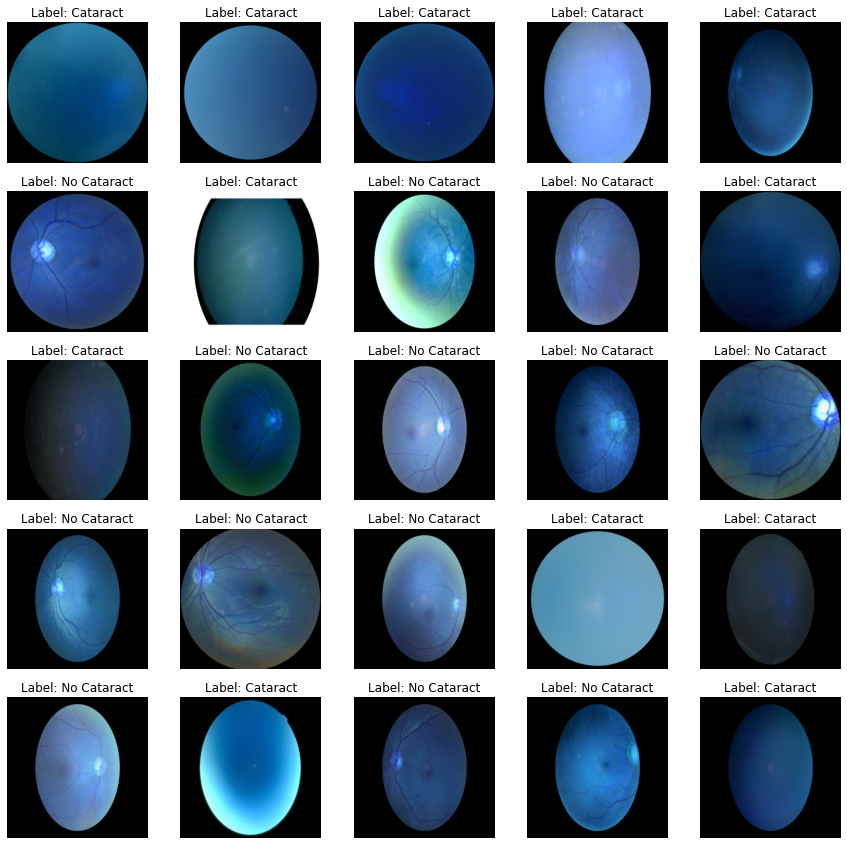

In [ ]:
train = cat_df + cat_no_df
shuffle(train)
show_images(train)

In [ ]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y = np.array([i[1] for i in train])

#Base line 

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer
cnn_model = Sequential()

cnn_model.add(InputLayer(input_shape=X_train.shape[1:]))
cnn_model.add(Conv2D(filters=10, kernel_size=3, activation='relu', padding='same'))
cnn_model.add(MaxPooling2D())
cnn_model.add(GlobalAveragePooling2D())
cnn_model.add(Dense(20, activation='relu'))
cnn_model.add(Dense(2, activation='sigmoid')) 

cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)
cnn_model.fit(X_train, y_train,
                  batch_size=32,
                  epochs=20,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/20
30/30 [==============================] - 2s 42ms/step - loss: 3.4797 - accuracy: 0.5379 - val_loss: 1.5286 - val_accuracy: 0.6008
Epoch 2/20
30/30 [==============================] - 1s 25ms/step - loss: 1.1256 - accuracy: 0.4337 - val_loss: 0.8944 - val_accuracy: 0.4748
Epoch 3/20
30/30 [==============================] - 1s 25ms/step - loss: 0.8258 - accuracy: 0.4747 - val_loss: 0.7284 - val_accuracy: 0.5882
Epoch 4/20
30/30 [==============================] - 1s 25ms/step - loss: 0.7309 - accuracy: 0.5347 - val_loss: 0.7579 - val_accuracy: 0.5504
Epoch 5/20
30/30 [==============================] - 1s 28ms/step - loss: 0.7160 - accuracy: 0.5884 - val_loss: 0.7305 - val_accuracy: 0.5588
Epoch 6/20
30/30 [==============================] - 1s 25ms/step - loss: 0.7344 - accuracy: 0.5705 - val_loss: 0.6672 - val_accuracy: 0.6261
Epoch 7/20
30/30 [==============================] - 1s 27ms/step - loss: 0.7306 - accuracy: 0.5653 - val_loss: 0.7309 - val_accuracy: 0.5630
Epoch 8/20
30

In [ ]:
score = cnn_model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.6869797110557556
Validation accuracy: 0.5798319578170776


#Train model ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50
model = Sequential()
model.add(ResNet50(include_top=False, pooling='max', weights='imagenet'))
model.add(Dense(NUM_CLASSES, activation='softmax'))
# ResNet-50 model is already trained, should not be trained
model.layers[0].trainable = True

In [ ]:
#opt = tfa.optimizers.LazyAdam()
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.025)
model.compile(optimizer='sgd', loss=loss, metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_5 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                   validation_data=(X_val, y_val))

Epoch 1/50
30/30 [==============================] - 30s 814ms/step - loss: 17.5895 - accuracy: 0.5895 - val_loss: 400471.8750 - val_accuracy: 0.5000
Epoch 2/50
30/30 [==============================] - 22s 724ms/step - loss: 2.2107 - accuracy: 0.6589 - val_loss: 3.0195 - val_accuracy: 0.5756
Epoch 3/50
30/30 [==============================] - 20s 685ms/step - loss: 1.4783 - accuracy: 0.7368 - val_loss: 80.0514 - val_accuracy: 0.5000
Epoch 4/50
30/30 [==============================] - 21s 686ms/step - loss: 0.7719 - accuracy: 0.8653 - val_loss: 53.1946 - val_accuracy: 0.5084
Epoch 5/50
30/30 [==============================] - 20s 683ms/step - loss: 0.5308 - accuracy: 0.8874 - val_loss: 1.0515 - val_accuracy: 0.6218
Epoch 6/50
30/30 [==============================] - 20s 683ms/step - loss: 0.4278 - accuracy: 0.9284 - val_loss: 1.2082 - val_accuracy: 0.8277
Epoch 7/50
30/30 [==============================] - 20s 683ms/step - loss: 0.4170 - accuracy: 0.9347 - val_loss: 1.8439 - val_accuracy

#Validation results

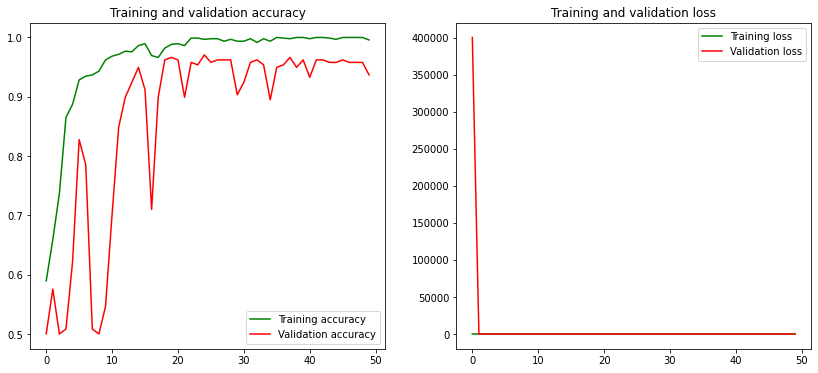

In [ ]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
plot_accuracy_and_loss(train_model)

In [ ]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.23338060081005096
Validation accuracy: 0.9369747638702393


In [ ]:
#get the predictions for the test data
#y_pred = np.argmax(model.predict(X_val,axis=-1))
y_pred = (model.predict(X_val) > 0.5).astype("int32")
#get the indices to be plotted
#y_true = np.argmax(y_val,axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
print('Classification Report')
target_names = ['Cataract', 'Normal']
print(classification_report(y_val, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

    Cataract       0.91      0.97      0.94       119
      Normal       0.97      0.90      0.93       119

   micro avg       0.94      0.94      0.94       238
   macro avg       0.94      0.94      0.94       238
weighted avg       0.94      0.94      0.94       238
 samples avg       0.94      0.94      0.94       238



#VGG16 MODEL

**Split our dataframe into test, train, validation dataframes**


In [ ]:
df_train = df_combined_random.sample(frac=0.8,random_state=42)
df_train.reset_index(drop=True)

# exclude the 80% that was already chosen, the remaining 20% will go into testing
df_test = df_combined_random.drop(df_train.index)
df_test.reset_index(drop=True)

print(len(df_combined_random))
print(len(df_train))
print(len(df_test))

1144
915
229


In [ ]:
df_train

filename     label
218     820_left.jpg  cataract
809    2703_left.jpg    normal
501    188_right.jpg  cataract
649    1102_left.jpg  cataract
323    2116_left.jpg  cataract
...              ...       ...
325    2133_left.jpg  cataract
186    2823_left.jpg    normal
123   2134_right.jpg  cataract
1053   2248_left.jpg  cataract
608    2126_left.jpg  cataract

[915 rows x 2 columns]

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.20,
            rotation_range=90,
#            width_shift_range=0.2,
#            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            shear_range=0.2,
            brightness_range=[0.3,1]    
#            zoom_range=0.2
            )

## for testing we don't want to do too much augmentation, we'll just scale it.

test_datagen=ImageDataGenerator(rescale=1./255.)

**Create test, train and validation image data generators**

In [ ]:
#image size
img_size = 224

In [ ]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=DATA_FOLDER,
x_col="filename",
y_col="label",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))

## validation set is created from the training set, 
## we set it at 20% of the training data in the previous code  -- need to 

valid_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=DATA_FOLDER,
x_col="filename",
y_col="label",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))



test_generator=test_datagen.flow_from_dataframe(
dataframe=df_test,
directory=DATA_FOLDER,
x_col="filename",
y_col="label",
batch_size=32,
#seed=42,
shuffle=False,
class_mode="categorical",
target_size=(img_size,img_size))

Found 732 validated image filenames belonging to 2 classes.
Found 183 validated image filenames belonging to 2 classes.
Found 229 validated image filenames belonging to 2 classes.


In [ ]:
## models to import
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

In [ ]:
# get VGG16 base model
vgg16 = keras.applications.vgg16.VGG16(input_shape=(224, 224, 3),
                                       weights='imagenet',
                                       include_top=False)

# add new dense layers at the top
x = keras.layers.Flatten()(vgg16.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu')(x)

## remember we are using 2 outputs only
predictions = keras.layers.Dense(2, activation='softmax')(x)

# define and compile model
model = keras.Model(inputs=vgg16.inputs, outputs=predictions)
for layer in vgg16.layers:
    layer.trainable = False
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

**Create check point and early stop**
<br>
A check point allows us to monitor the acuraccy and perform some task, in this case we will save the model as a file.

The early stop will monitor accuracy for a 'patience' parameter and if there is no improvement it will stop.

In [ ]:
checkpoint = ModelCheckpoint("vgg16_1.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             period=1)

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=3, 
                      verbose=1, 
                      mode='auto')

**Constants for our training run**
<br>
SPE is 'steps per epoch'
<br>
n_val_steps is 'number of validation steps'

In [ ]:
batch_size = 32
n_spe = train_generator.samples // batch_size
n_val_steps = valid_generator.samples // batch_size
n_epochs = 50
print(n_spe,n_val_steps)

22 5


In [ ]:
hist = model.fit(train_generator,
                        steps_per_epoch=n_spe,
                        validation_data=valid_generator,
                        validation_steps=n_val_steps,
                        epochs=n_epochs,
                        shuffle=True,
                        workers=5,
                        use_multiprocessing=True,
                        callbacks=[checkpoint,early])

Epoch 1/50
22/22 [==============================] - ETA: 0s - loss: 1.6753 - accuracy: 0.5457
Epoch 00001: val_accuracy improved from -inf to 0.58750, saving model to vgg16_1.h5
22/22 [==============================] - 79s 3s/step - loss: 1.6753 - accuracy: 0.5457 - val_loss: 0.6995 - val_accuracy: 0.5875
Epoch 2/50
22/22 [==============================] - ETA: 0s - loss: 0.7290 - accuracy: 0.6571
Epoch 00002: val_accuracy improved from 0.58750 to 0.73125, saving model to vgg16_1.h5
22/22 [==============================] - 70s 3s/step - loss: 0.7290 - accuracy: 0.6571 - val_loss: 0.5400 - val_accuracy: 0.7312
Epoch 3/50
22/22 [==============================] - ETA: 0s - loss: 0.5851 - accuracy: 0.7243
Epoch 00003: val_accuracy did not improve from 0.73125
22/22 [==============================] - 59s 2s/step - loss: 0.5851 - accuracy: 0.7243 - val_loss: 0.6771 - val_accuracy: 0.6750
Epoch 4/50
22/22 [==============================] - ETA: 0s - loss: 0.5490 - accuracy: 0.7557
Epoch 00004

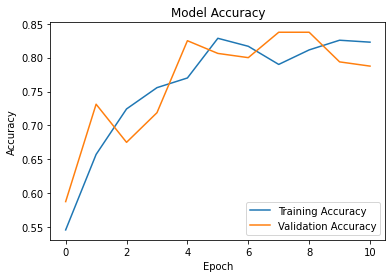

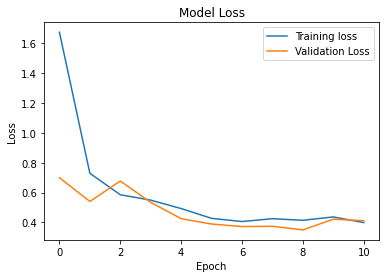

In [ ]:
#Plot accuracy versus loss
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training Accuracy","Validation Accuracy"])
plt.show()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Training loss","Validation Loss"])
plt.show()

In [ ]:
test_generator.reset()

In [ ]:
pred = model.predict_generator(test_generator,verbose=1,steps=test_generator.samples/batch_size)

7/7 [==============================] - 17s 2s/step


In [ ]:
#Prediction raw data
## let's get the first 10 rows
print(pred[0:10])

[[5.5993424e-04 9.9944001e-01]
 [7.1218264e-01 2.8781733e-01]
 [9.5175731e-01 4.8242651e-02]
 [9.7385639e-01 2.6143584e-02]
 [1.3423417e-04 9.9986577e-01]
 [1.2521943e-01 8.7478060e-01]
 [6.2580517e-04 9.9937421e-01]
 [4.2995184e-06 9.9999571e-01]
 [3.5044482e-01 6.4955521e-01]
 [5.4806226e-01 4.5193771e-01]]


#Convert raw prediction data
Let's convert the raw data into something more friendly, 1's and 0's. Argmax will do this for us!

In [ ]:
predicted_class_idx=np.argmax(pred,axis=1)
## print the same 10 rows
print(predicted_class_idx[0:10])

[1 0 0 0 1 1 1 1 1 0]


In [ ]:
print(len(predicted_class_idx))

229


#Evaluate our model's accuracy


In [ ]:
model.evaluate(test_generator,use_multiprocessing=True,workers=10)

8/8 [==============================] - 17s 345ms/step - loss: 0.2659 - accuracy: 0.8865


[0.2659149169921875, 0.8864628672599792]

#Convert one-hot category labels to text labels


In [ ]:
valid_generator.class_indices.items()

dict_items([('cataract', 0), ('normal', 1)])

In [ ]:
valid_labels = dict((value,key) for key,value in valid_generator.class_indices.items())
pred_labels = [valid_labels[key] for key in predicted_class_idx]

In [ ]:
pred_labels[1:10]

['cataract',
 'cataract',
 'cataract',
 'normal',
 'normal',
 'normal',
 'normal',
 'normal',
 'cataract']

#Build a new dataframe


In [ ]:
filenames = test_generator.filenames
prediction_df = pd.DataFrame({'Filename': filenames,'Prediction': pred_labels})
prediction_df.head()

Filename Prediction
0   2663_left.jpg     normal
1    625_left.jpg   cataract
2  2213_right.jpg   cataract
3   2234_left.jpg   cataract
4   3086_left.jpg     normal

#Verify prediction dataframe results

In [ ]:
prediction_df.iloc[35]

Filename      2437_right.jpg
Prediction            normal
Name: 35, dtype: object

In [ ]:
print(test_generator.filenames[35])
print(test_generator.labels[35])

2437_right.jpg
1


#Correct vs. Incorrect list

In [ ]:
test_file_names=test_generator.filenames  # sequential list of name of test files of each sample
test_labels=test_generator.labels # is a sequential list  of test labels for each image sample
class_dict= test_generator.class_indices # a dictionary where key is the class name and value is the label for the class

print (class_dict) # have a look at the dictionary
new_dict={} 

for key in class_dict: # set key in new_dict to value in class_dict and value in new_dict to key in class_dict
    value = class_dict[key]
    new_dict[value] = key

print('  RESULT  PREDICT      TRUE CLASS       FILENAME ' ) # adjust spacing based on your class names

for i, p in enumerate(pred):
    pred_index=np.argmax(p) # get the index that has the highest probability
    pred_class=new_dict[pred_index]  # find the predicted class based on the index
    true_class=new_dict[test_labels[i]] # use the test label to get the true class of the test file
    file=test_file_names[i]
    
    if true_class == pred_class:
        result = "Correct"
    else:
        result = "Wrong  "
    
    
    print(f' {result}   {pred_class}    {true_class}      {file}')

{'cataract': 0, 'normal': 1}
  RESULT  PREDICT      TRUE CLASS       FILENAME 
 Correct   normal    normal      2663_left.jpg
 Correct   cataract    cataract      625_left.jpg
 Correct   cataract    cataract      2213_right.jpg
 Correct   cataract    cataract      2234_left.jpg
 Correct   normal    normal      3086_left.jpg
 Correct   normal    normal      2647_left.jpg
 Correct   normal    normal      2513_right.jpg
 Correct   normal    normal      4271_left.jpg
 Wrong     normal    cataract      2122_right.jpg
 Correct   cataract    cataract      2137_left.jpg
 Correct   cataract    cataract      970_left.jpg
 Correct   cataract    cataract      2115_right.jpg
 Correct   cataract    cataract      330_left.jpg
 Correct   normal    normal      3344_left.jpg
 Correct   cataract    cataract      2138_right.jpg
 Correct   cataract    cataract      2123_left.jpg
 Correct   cataract    cataract      2151_left.jpg
 Wrong     normal    cataract      1483_left.jpg
 Correct   cataract    catara

#Another approach to generator data

In [ ]:
x_test, y_test = test_generator.next()


In [ ]:
print(len(x_test))
print(len(y_test))


## compare this length to our prediction data and notice the difference.  

print(len(pred))

32
32
229


In [ ]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

1/1 [==============================] - 1s 511ms/step - loss: 0.3122 - accuracy: 0.8438
loss: 0.31215542554855347
Accuracy: 0.84375


#Prediction vs Test image grid

In [ ]:
test_image_data, test_labels = test_generator.next()

In [ ]:
print(test_image_data.shape)
print(test_labels.shape)

(32, 224, 224, 3)
(32, 2)


In [ ]:
z = 0
#test filename

test_file_names=test_generator.filenames[z]
print(test_file_names)

test_labels_example=test_generator.labels[z]
print(test_labels_example)

pred_labels[z]

2663_left.jpg
1


'normal'

#Convert test labels

In [ ]:
test_labels[5]

array([0., 1.], dtype=float32)

In [ ]:
test_class_idx=np.argmax(test_labels,axis=1)
#test_class_idx[4]
test_class_idx

array([0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 1])

#Plot our comparison grid

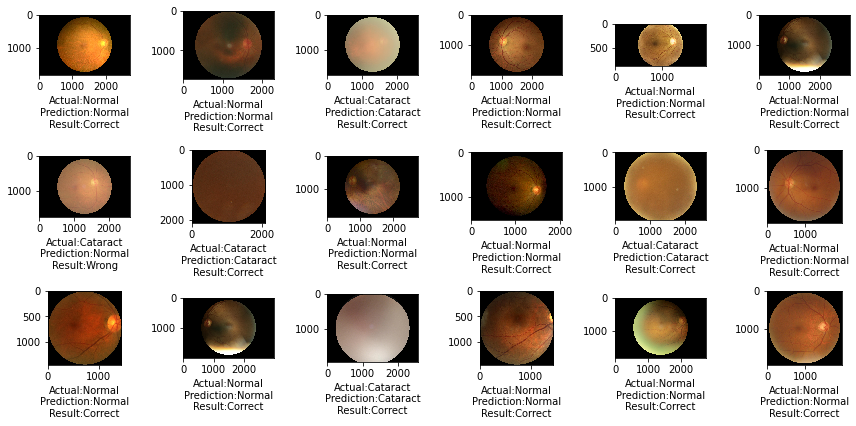

In [ ]:
plt.figure(figsize=(12,6))
for i in range(18):
    sample = random.choice(range(test_generator.samples))
#    print(str(sample))
    img = test_generator.filenames[sample]
    image = cv2.imread(os.path.join(DATA_FOLDER, img))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    category = test_generator.labels[sample]
    pred_category = pred_labels[sample]

#    sample = random.choice(range(0,test_generator.samples))    
#    image = test_image_data[sample]
#    category = test_class_idx[sample]
#    pred_category = pred_labels[sample]
       
    
    if category== 1:
        label = "Normal"
    else:
        label = "Cataract"
        
    if pred_category== "normal":
        pred_label = "Normal"
    else:
        pred_label = "Cataract"

    if label == pred_label:
        result = "Correct"
    else:
        result = "Wrong"

        
    plt.subplot(3,6,i+1)
    plt.imshow(image_rgb, interpolation='nearest')
    plt.xlabel("Actual:{}\nPrediction:{}\nResult:{}".format(label,pred_label,result))
plt.tight_layout() 

#Classification report

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
print('Classification Report')
target_names = ['Cataract', 'Normal']
print(classification_report(test_generator.classes, predicted_class_idx, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

    Cataract       0.96      0.80      0.87       112
      Normal       0.84      0.97      0.90       117

    accuracy                           0.89       229
   macro avg       0.90      0.88      0.89       229
weighted avg       0.90      0.89      0.89       229



#Confusion matrix

In [ ]:
cm = confusion_matrix(test_generator.labels, predicted_class_idx)
print('Confusion Matrix')
cm

Confusion Matrix


array([[ 90,  22],
       [  4, 113]])

#Plot confusion matrix

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm_plot_labels = ['cataract','normal']

Confusion matrix, without normalization
[[ 90  22]
 [  4 113]]


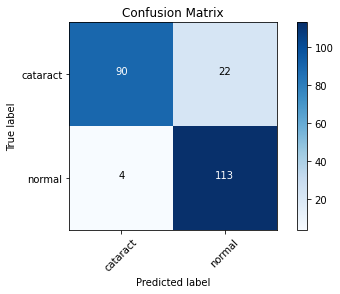

In [ ]:
import itertools
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')